# Import libraries

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import spearmanr
import pandas as pd
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split
import cv2
from skimage.morphology import binary_opening,binary_closing,disk, binary_dilation
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import data
from skimage.util import img_as_float
from skimage.filters import gabor_kernel
from skimage import data, segmentation, feature, future
from sklearn.ensemble import RandomForestClassifier
from functools import partial
from scipy import ndimage as ndi
import numpy as np
from skimage.feature import graycomatrix, graycoprops
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns

def postprocess_mask(mask):
    mask=binary_opening(mask,disk(5))
    mask=binary_closing(mask,disk(8))
    return mask

def calc_nc_ratio(img_gray,nucleus_threshold=0.4,cytoplasm_threshold=0.6):
    nucleus_mask=img_gray<=nucleus_threshold
    nucleus_mask=postprocess_mask(nucleus_mask)

    cytoplasm_mask=img_gray<=cytoplasm_threshold
    cytoplasm_mask=postprocess_mask(cytoplasm_mask)
    cytoplasm_mask=np.logical_and(cytoplasm_mask,~nucleus_mask)

    nucleus_area=np.sum(nucleus_mask)
    cytoplasm_area=np.sum(cytoplasm_mask)
    return nucleus_area/(nucleus_area+cytoplasm_area)


# Load Data

In [2]:
# Load the urothelial cell dataset from pickle file
urothelial_cells=pd.read_pickle("urothelial_cell_toy_data.pkl")
images=np.transpose(urothelial_cells["X"].numpy()*255,(0,2,3,1)).astype(np.uint8)

# Extract labels
labels=urothelial_cells["y"]

# Filter out images with no nucleus (label==2)
no_nucleus=(labels==2).sum(axis=(1,2))==0
images=images[~no_nucleus]
labels=labels[~no_nucleus]

# Split data into train/test sets (80/20)
X_train,X_test,Y_train,Y_test=train_test_split(images,labels,test_size=0.2,stratify=labels.mean((1,2))>=np.median(labels.mean((1,2))),random_state=42)

# Further split training data into train/validation sets (80/20)
X_train,X_val,Y_train,Y_val=train_test_split(X_train,Y_train,test_size=0.2,stratify=Y_train.mean((1,2))>=np.median(Y_train.mean((1,2))),random_state=42)

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

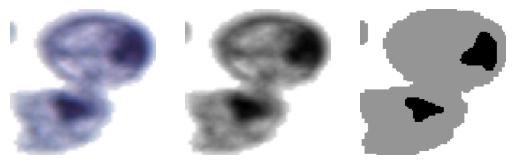

In [3]:
idx=2
im_gray=cv2.cvtColor(X_train[idx],cv2.COLOR_RGB2GRAY)
plt.subplot(1,3,1)
plt.imshow(X_train[idx])
plt.axis("off")
plt.subplot(1,3,2)
plt.imshow(im_gray,cmap="gray")
plt.axis("off")
plt.subplot(1,3,3)
plt.imshow(Y_train[idx],cmap="Greys")
plt.axis("off")

# New Filters & Features

## Gabor Filters

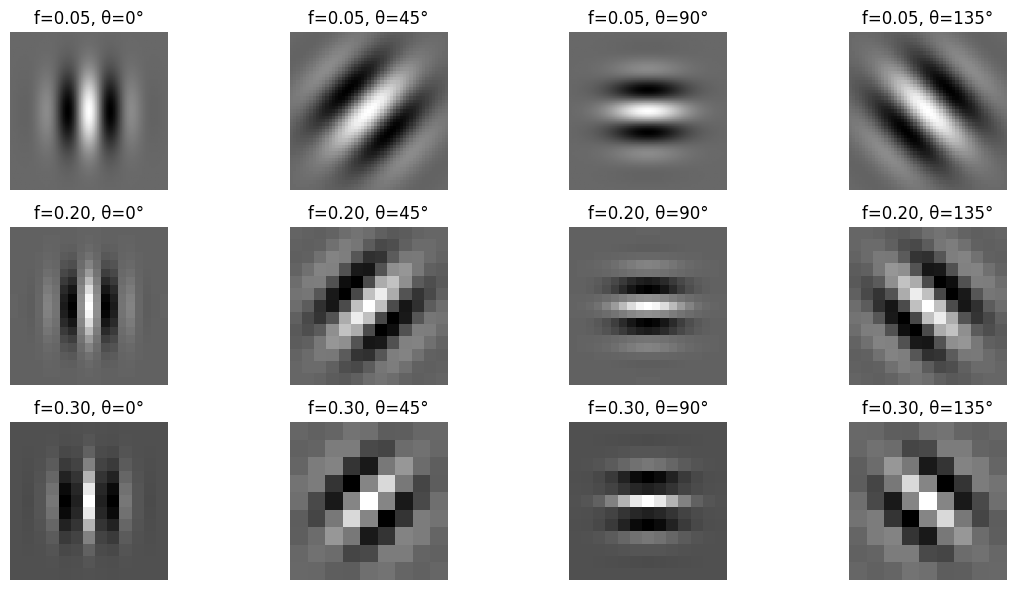

In [ ]:
from skimage.filters import gabor_kernel

# Function to plot Gabor kernels for different frequencies and orientations
def plot_gabor_kernels(frequencies, thetas):
    fig, axs = plt.subplots(len(frequencies), len(thetas), figsize=(12, 6))
    for i, freq in enumerate(frequencies):
        for j, theta in enumerate(thetas):
            kernel = gabor_kernel(frequency=freq, theta=theta)
            axs[i, j].imshow(np.real(kernel), cmap='gray')
            axs[i, j].set_title(f"f={freq:.2f}, θ={np.degrees(theta):.0f}°")
            axs[i, j].axis('off')
    plt.tight_layout()
    plt.show()

# Try with some sample frequencies and orientations
frequencies = [0.05, 0.2, 0.3]
thetas = [0, np.pi/4, np.pi/2, 3*np.pi/4]
# Visualize Gabor kernels for the specified frequencies and orientations
plot_gabor_kernels(frequencies, thetas)

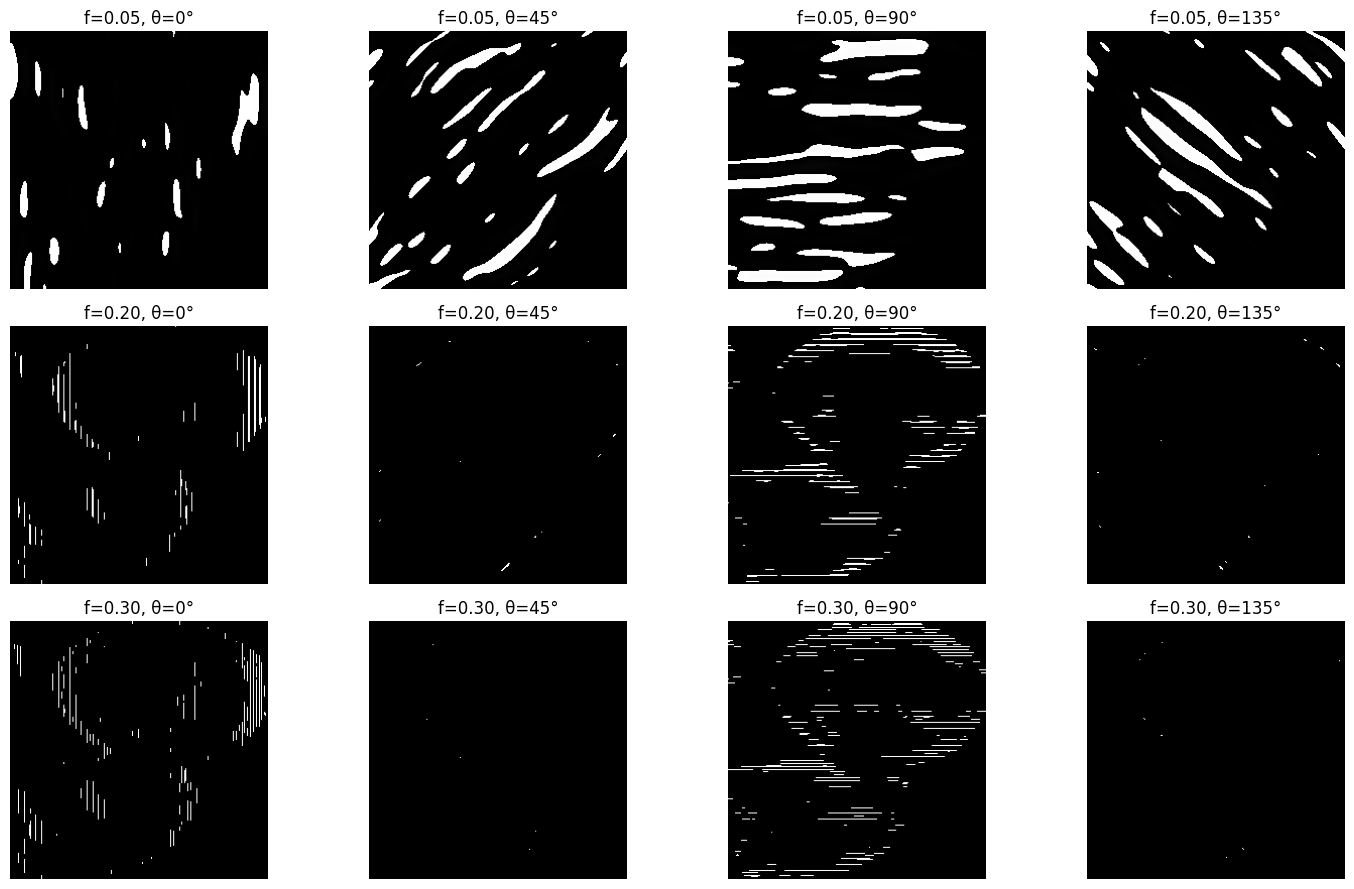

In [5]:
from scipy.ndimage import convolve

def apply_gabor_filters(image, frequencies, thetas):
    filtered_images = []
    for freq in frequencies:
        for theta in thetas:
            kernel = gabor_kernel(frequency=freq, theta=theta)
            real = convolve(image, np.real(kernel), mode='reflect')
            filtered_images.append((real, freq, theta))
    return filtered_images

def plot_filtered_images(filtered_results):
    n = len(filtered_results)
    cols = 4
    rows = int(np.ceil(n / cols))

    fig, axs = plt.subplots(rows, cols, figsize=(15, rows * 3))
    axs = axs.flatten()
    for i, (img, freq, theta) in enumerate(filtered_results):
        axs[i].imshow(img, cmap='gray')
        axs[i].set_title(f"f={freq:.2f}, θ={np.degrees(theta):.0f}°")
        axs[i].axis('off')
    for j in range(i+1, len(axs)):
        axs[j].axis('off')
    plt.tight_layout()
    plt.show()

# Apply Gabor filters to the grayscale image
filtered_results = apply_gabor_filters(im_gray, frequencies, thetas)

# Visualize the results of applying Gabor filters
plot_filtered_images(filtered_results)

## Gray-Level Co-Occurrence

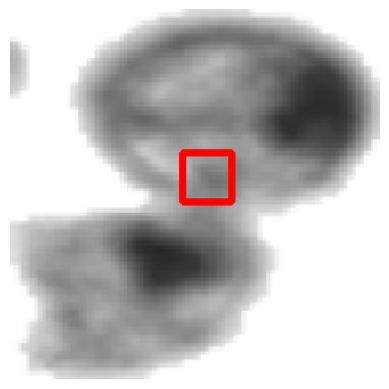

(np.float64(-0.5), np.float64(31.5), np.float64(31.5), np.float64(-0.5))

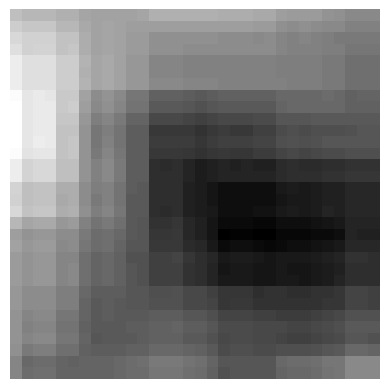

In [ ]:
from skimage.draw import rectangle_perimeter

# Define patch location and size
r,c=[100,120]
PATCH_SIZE=32
patch=im_gray[r:r+PATCH_SIZE,c:c+PATCH_SIZE]

# Create rectangle perimeter coordinates for visualization
rmin,rmax,cmin,cmax=r,r+PATCH_SIZE,c,c+PATCH_SIZE
r_,c_=rectangle_perimeter((rmin,cmin),(rmax,cmax))
rec_lbl=np.zeros(im_gray.shape)
rec_lbl[r_,c_]=1
rec_lbl=binary_dilation(rec_lbl,disk(2))
# Convert to RGB and highlight rectangle in red
im_gray_new=cv2.cvtColor(im_gray.copy(),cv2.COLOR_GRAY2RGB)
im_gray_new[rec_lbl]=[255,0,0]

plt.imshow(im_gray_new)
plt.axis("off")
plt.show()


plt.imshow(patch,cmap="gray")
plt.axis("off")


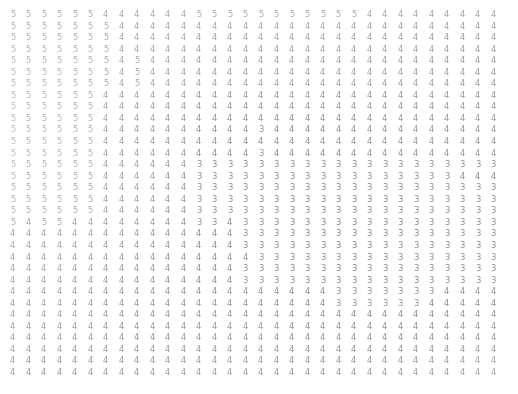

In [ ]:
for i in range(patch.shape[0]):
    for j in range(patch.shape[1]):
        text = plt.text(j/patch.shape[0], i/patch.shape[1], str(round(patch[i, j]//32,0)),
                       ha="center", va="center", color="k", alpha=(1-(patch/255.)[i, j]/1.5)**2, fontsize=6)#**2/2
plt.axis("off")
plt.gca().invert_yaxis()

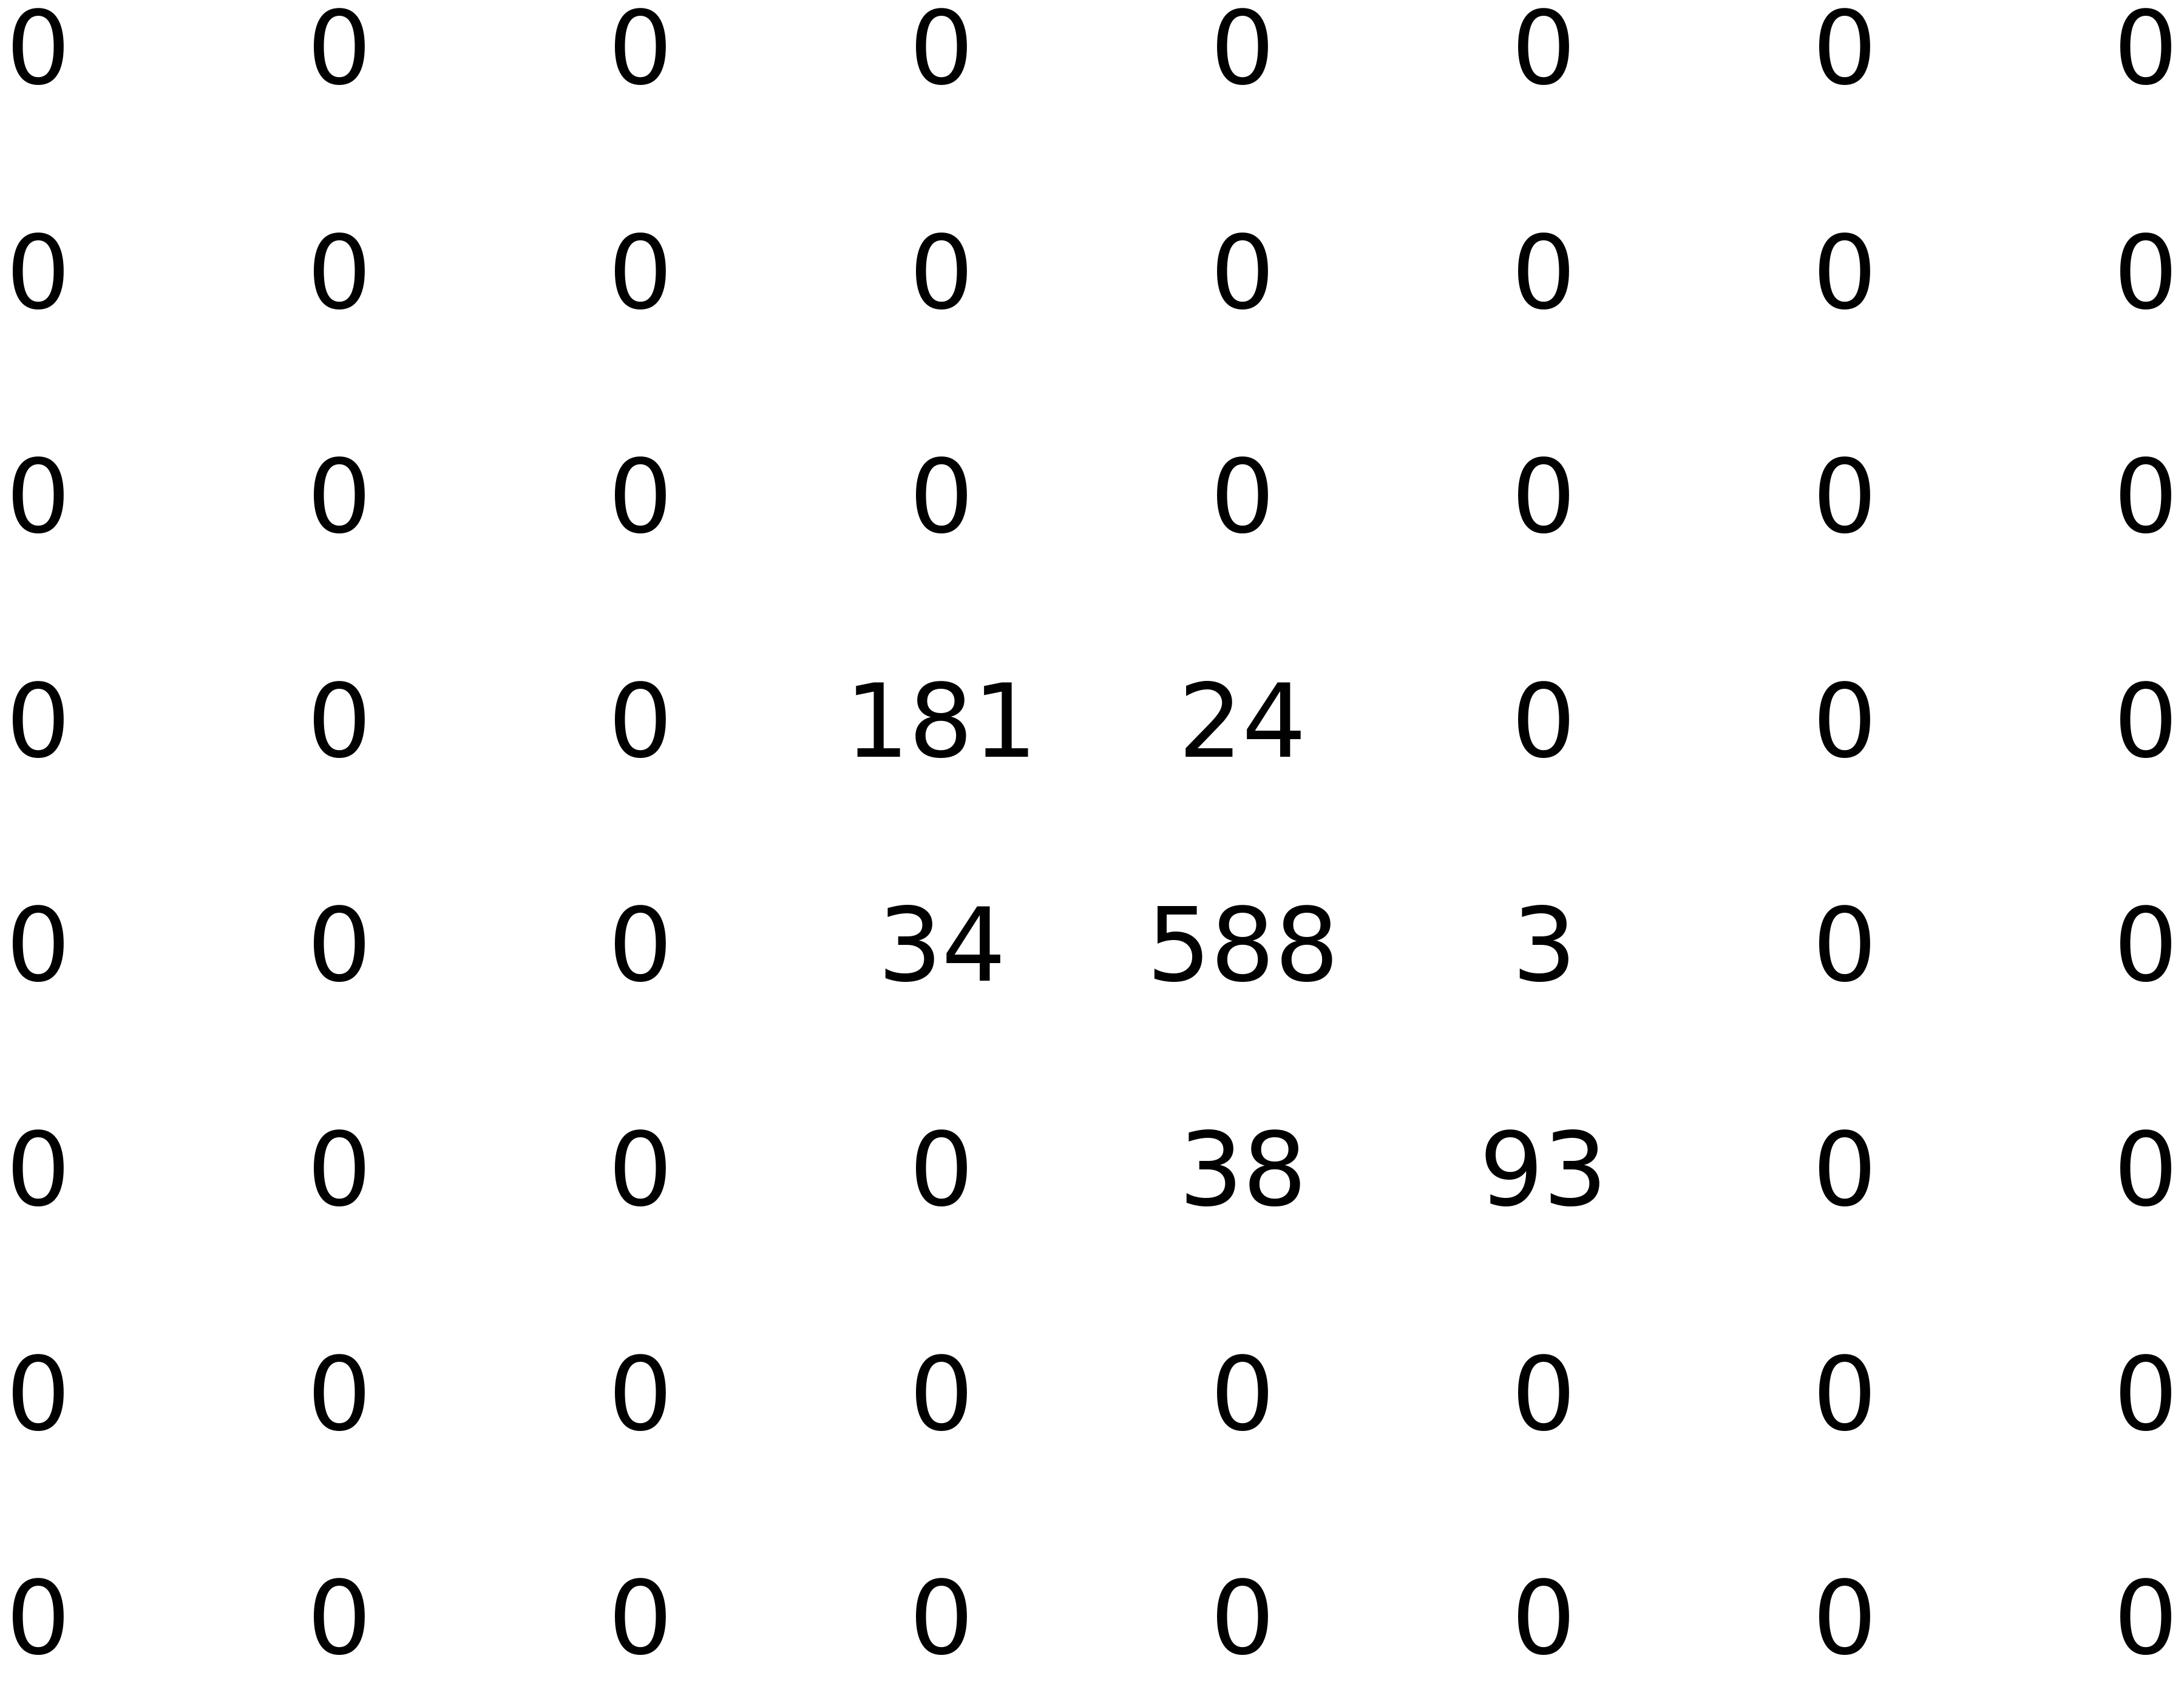

In [ ]:
# Calculate the Gray Level Co-occurrence Matrix (GLCM) for the patch
# Display the GLCM values as text annotations on a plot
from skimage.feature import graycomatrix
glcm = graycomatrix(patch//32, distances=[1], angles=[45*np.pi/180], levels=8, symmetric=False, normed=False)[:,:,0,0]
for i in range(glcm.shape[0]):
    for j in range(glcm.shape[1]):
        text = plt.text(j, i, str(glcm[i, j]),
                       ha="center", va="center", color="k", fontsize=120)#**2/2
plt.axis("off")
plt.gca().invert_yaxis()

# Feature Extraction

In [9]:
# Import feature extraction utilities and extract features from a small subset of training data
# extract_and_organize_features calculates multiple feature maps (RGB, grayscale, Gabor, Sobel, GLCM, multiscale) 
# and returns both stacked features and a dictionary mapping feature types to their corresponding feature maps
from feature_extraction_utils import extract_and_organize_features
# Run on X_toy dataset (X_train[11:15])
X_toy = X_train[11:15]
X_toy_features, X_toy_features_dict = extract_and_organize_features(X_toy)


(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

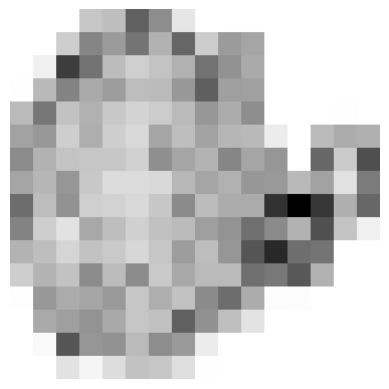

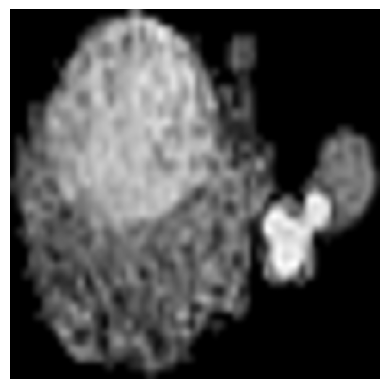

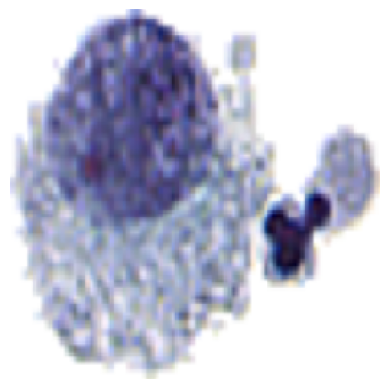

In [10]:
i=2
plt.figure()
plt.imshow(X_toy_features_dict["glcm"][i][...,0],cmap="gray_r")
plt.axis("off")
plt.figure()
plt.imshow(X_toy_features_dict["multiscale"][i][...,0],cmap="gray_r")
plt.axis("off")
plt.figure()
plt.imshow(X_toy_features_dict["RGB"][i]/255)
plt.axis("off")

In [11]:
# Transform images into higher dimensional feature space by calculating multiple pixelwise features
# Extract RGB, Gabor, and Sobel features for train/val/test sets (GLCM and multiscale features disabled)
use_glcm = False
use_multiscale = False

X_train_features, X_train_features_dict = extract_and_organize_features(
    X_train,
    use_glcm=use_glcm,
    use_multiscale=use_multiscale
)

X_val_features, X_val_features_dict = extract_and_organize_features(
    X_val,
    use_glcm=use_glcm,
    use_multiscale=use_multiscale
)

X_test_features, X_test_features_dict = extract_and_organize_features(
    X_test,
    use_glcm=use_glcm,
    use_multiscale=use_multiscale
)


(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

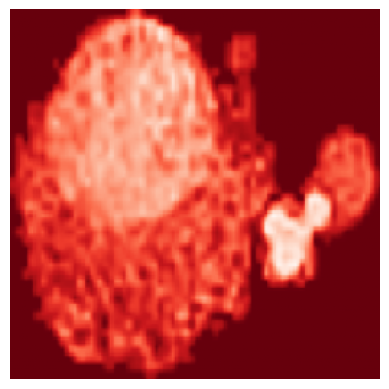

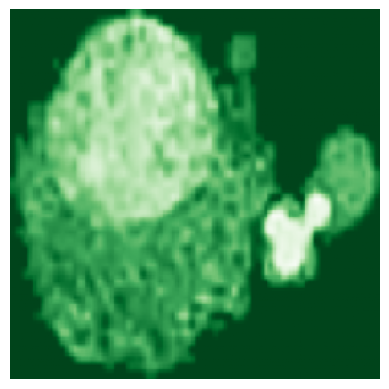

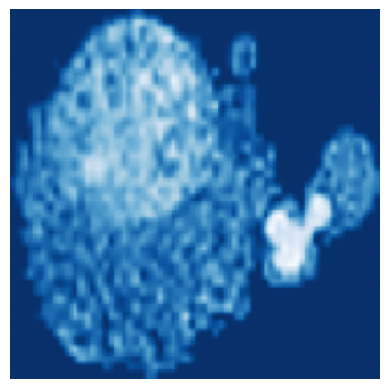

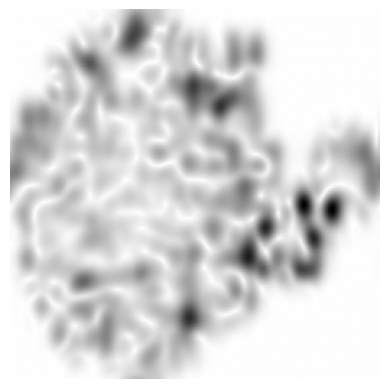

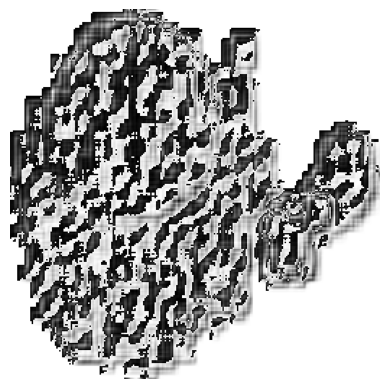

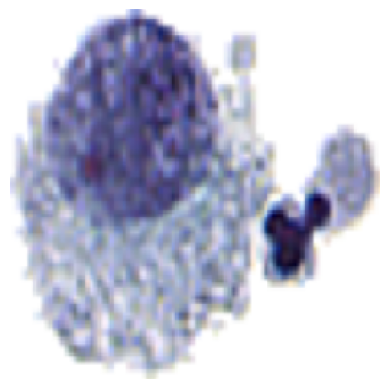

In [12]:
i=13
plt.figure()
plt.imshow(X_train_features_dict["RGB"][i][...,0],cmap="Reds")
plt.axis("off")
plt.figure()
plt.imshow(X_train_features_dict["RGB"][i][...,1],cmap="Greens")
plt.axis("off")
plt.figure()
plt.imshow(X_train_features_dict["RGB"][i][...,2],cmap="Blues")
plt.axis("off")
plt.figure()
plt.imshow(X_train_features_dict["gabor"][i][...,0],cmap="gray_r")
plt.axis("off")
plt.figure()
plt.imshow(X_train_features_dict["sobel"][i][...,0],cmap="gray_r")
plt.axis("off")
plt.figure()
plt.imshow(X_train_features_dict["RGB"][i]/255)
plt.axis("off")